# runningmeans

This is the second step in reproducing the cluster analysis from Sara and David following Amini et al 2019
https://doi.org/10.1007/s00382-018-4409-7

This program:
1. Reads data:
* Input File: `/project/predictability/kpegion/wxregimes/era-interim/erai.z500_u250_pna_DJF.1980-2015.nc`
2. Sorts data and time to be in chronological order
3. Makes 5-day running means
4. Extracts data for 19801201 to 20150301
5. Writes data to single netcdf file containing both variables
* Output File: `/project/predictability/kpegion/wxregimes/era-interim/erai.z500_u250_pna_5dyrm_DJF.1980-2015.nc`

### Function to calculate the running running mean over the season from Dec 1 to Mar 2 (or Mar 1 if Leap year)

In [1]:
def rm_season(da,window,yrs_list,varname):

    nt,ny,nx=da.shape
    ndays=91
    nyr=int(nt/ndays)
    
    # Create empty list to store each years 5-day running mean
    ds_rm_tmp=[]
    
    # Loop over all years
    for yr in yrs_list:
         
        # Define the start date as Dec 1 of the previous year and the end date to get
        # a total of 92 days
        start_date=pd.to_datetime(str(yr-1)+'1201')
        end_date=start_date+pd.DateOffset(days=ndays)
        
        # Select just the 92 days
        ds_this_year=da.sel(time=slice(start_date,end_date))
        
        # Calculate the running mean & append to list
        ds_rm_tmp.append(ds_this_year.rolling(time=window,center=True).mean().dropna(dim='time'))

    # Combine each year's 5-day running mean together in the time index and convert to xarray.Dataset
    ds_rm = xr.combine_nested(ds_rm_tmp, concat_dim='time').to_dataset(name=varname)
    
    # Return the xarray.Dataset
    return ds_rm

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
yrs_list=np.arange(1981,2016)

### Define input and output files

In [4]:
# Input
path='/project/predictability/kpegion/wxregimes/era-interim/'
fname='erai.z500_u250_pna_DJF.1980-2015.nc'

# Output
out_path='/project/predictability/kpegion/wxregimes/era-interim/'
ofname='erai.z500_u250_pna_5dyrm_DJF.1980-2015.nc'
outfile=out_path+ofname

### Read the data

In [5]:
ds=xr.open_dataset(path+fname,decode_times=True)
ds

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 4365)
Coordinates:
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2015-12-31
Data variables:
    z500     (time, lat, lon) float64 ...
    u250     (time, lat, lon) float64 ...

### Put data in consecutive order

In [6]:
ds=ds.reindex(time=sorted(ds['time'].values))

### Quick look plots

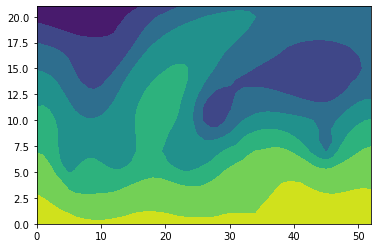

In [7]:
tmp=ds.sel(time='19801203')
plt.contourf(tmp['z500'][::-1,:])

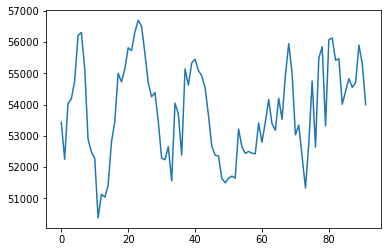

In [8]:
plt.plot(ds['z500'][0:92,12,25])

### Calculate the 5-day running means for Z500 and U250 and combine them together in the same `xarray.Dataset`

In [9]:
z500_rm=rm_season(ds['z500'],5,yrs_list,'z500')
u250_rm=rm_season(ds['u250'],5,yrs_list,'u250')
ds_5dayrm=xr.merge([z500_rm,u250_rm])

In [10]:
ds_5dayrm

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 3080)
Coordinates:
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * time     (time) datetime64[ns] 1980-12-03 1980-12-04 ... 2015-02-28
Data variables:
    z500     (time, lat, lon) float64 4.895e+04 4.89e+04 ... 5.784e+04 5.781e+04
    u250     (time, lat, lon) float64 6.428 6.05 5.769 ... 9.005 7.433 5.919

### Quick look plots

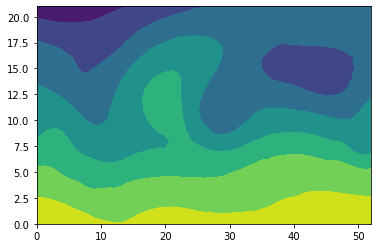

In [11]:
plt.contourf(ds_5dayrm['z500'][0,::-1,:])

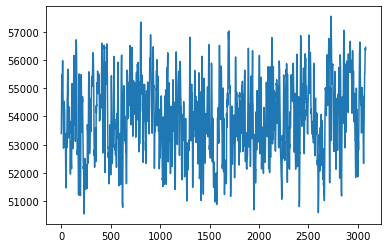

In [12]:
plt.plot(ds_5dayrm['z500'][:,12,25])

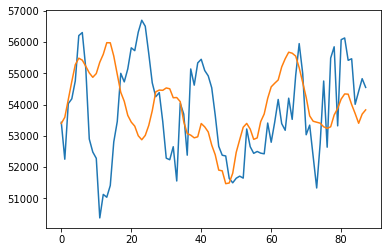

In [13]:
plt.plot(ds['z500'][0:88,12,25])
plt.plot(ds_5dayrm['z500'][0:88,12,25])

### Write to netcdf

In [14]:
ds_5dayrm.to_netcdf(outfile)